### Imports  
*All the Python imports go here.*

In [1]:
import os, re, math, time, glob
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import decomposition
from TextProcessor import *
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2019)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/mdleiton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


## Read data

## Training and Test 

In [6]:
df_model_training = pd.read_csv('../data/final_ecuador_data/final_training.csv')
df_model_test = pd.read_csv('../data/final_ecuador_data/final_test.csv')

In [7]:
df_model_training

,diario,id_news,snippet,category,time,title,year,tokens-headline,tokens-snippet,tokens-headline-stopwords-stemming,tokens-headline-stopwords,tokens-headline-stemming,tokens-snippet-stopwords-stemming,tokens-snippet-stopwords,tokens-snippet-stemming
0,El Universo,ecuador_eluniverso_2015_2,La caida 2-0 ante Chile en el debut de Ecuador...,sport,12 Jun. 2015,Ecuador hace pausa y se relaja en Santiago,2015.0,ecuador hace pausa relaja santiago,caida ante chile debut ecuador copa america qu...,hac paus relaj santiag,hace pausa relaja santiago,ecuador hac paus relaj santiag,caid chil debut cop amer qued envi trav univer...,caida chile debut copa america quedo enviaron ...,caid ante chil debut ecuador cop amer qued env...
1,El Comercio (Ecuador),ecuador_elcomercio_2017_26,"Bucaram, quien regreso el jueves a Ecuador tra...",polit,17 Jun. 2017,Abdala Bucaram encabeza marcha de seguidores p...,2017.0,abdala bucaram encabeza marcha seguidores por ...,bucaram quien regreso jueves ecuador tras anos...,abdal bucaram encabez march seguidor,abdala bucaram encabeza marcha seguidores,abdal bucaram encabez march seguidor por guaya...,bucaram qui regres juev tras anos autoexili co...,bucaram regreso jueves tras anos autoexilio co...,bucaram qui regres juev ecuador tras anos auto...
2,NaN,NaN,Las becas siempre son un aliciente para los as...,educ,15 feb. 2018 -,Opciones de becas y otras ayudas economicas en...,NaN,opciones becas otras ayudas economicas tres un...,las becas siempre son aliciente para los aspir...,opcion bec ayud econom tres univers,opciones becas ayudas economicas tres universi...,opcion bec otras ayud econom tres univers,bec siempr alicient par aspir universitari mom...,becas siempre aliciente aspirantes universitar...,las bec siempr son alicient par los aspir univ...
3,El Comercio (Ecuador),ecuador_elcomercio_2016_99,Los gobiernos de Ecuador y Emiratos Arabes Uni...,polit,10 Nov. 2016,Ecuador y Emiratos Arabes firman acuerdo sobre...,2016.0,ecuador emiratos arabes firman acuerdo sobre a...,los gobiernos ecuador emiratos arabes unidos s...,emirat arab firm acuerd sobr asunt tributari,emiratos arabes firman acuerdo asuntos tributa...,ecuador emirat arab firm acuerd sobr asunt tri...,gobi emirat arab unid suscrib acuerd transport...,gobiernos emiratos arabes unidos suscribieron ...,los gobi ecuador emirat arab unid suscrib acue...
4,La Hora (Ecuador),ecuador_lahora_2015_22,Ante el partido de hoy a las 19:00 que enfrent...,sport,7 Oct. 2015,Hinchadas se juntan para vivir la pasion del f...,2015.0,hinchadas juntan para vivir pasion del futbol,ante partido hoy las que enfrenta ecuador arge...,hinch junt par viv pasion futbol,hinchadas juntan vivir pasion futbol,hinch junt par viv pasion del futbol,part hoy enfrent argentin repas algun lugar pa...,partido hoy enfrenta argentina repasa lugares ...,ante part hoy las que enfrent ecuador argentin...
5,El Comercio (Ecuador),ecuador_elcomercio_2016_78,Ecuador consiguio de la Union Europea (UE) la ...,economi,8 Nov. 2016,El acuerdo con la Union Europea excluye 91 pro...,2016.0,acuerdo con union europea excluye productos ag...,ecuador consiguio union europea exclusion grup...,acuerd union europe exclu product agricol,acuerdo union europea excluye productos agricolas,acuerd con union europe exclu product agricol,consigui union europe exclusion grup ministr c...,consiguio union europea exclusion grupo minist...,ecuador consigui union europe exclusion grup m...
6,La Hora (Ecuador),ecuador_lahora_2017_72,En Ecuador la cantidad de alimentos que se pro...,health,21 ago. 2017,10.9% de la poblacion de Ecuador esta subalime...,2017.0,poblacion ecuador esta subalimentada,ecuador cantidad alimentos que producen excede...,poblacion subaliment,poblacion subalimentada,poblacion ecuador esta subaliment,cantid aliment produc exced necesit par atend ...,cantidad alimentos producen excede necesita at...,ecuador cantid aliment que produc exced que ne...
7,El Comercio,ecuador_elcomercio_2015_37,Durante mas de ocho 

In [8]:
df_model_training.category.value_counts(normalize=True)

polit      0.173423
economi    0.173423
educ       0.168919
health     0.164414
sport      0.164414
crime      0.155405
Name: category, dtype: float64

In [9]:
df_model_test.category.value_counts(normalize=True)

educ       0.195946
economi    0.182432
crime      0.182432
polit      0.168919
health     0.162162
sport      0.108108
Name: category, dtype: float64

# Prediction

Using the training and test dataset, we will predict the category of news.

### SVM Classifier

In [10]:
frames = [df_model_training, df_model_test]
df_model = pd.concat(frames)

In [11]:
# Create TFIDF matrix.
corpus = df_model['tokens-headline-stopwords-stemming']
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(corpus)
print(matrix.shape)

(592, 1430)


In [12]:
# Split my data on training y test.
num_training = len(df_model_training)
X_train = matrix[:num_training,:]
X_test = matrix[num_training:,:]
y_train = df_model["category"].values[:num_training]
y_test = df_model['category'].values[num_training:]

### Any Neural Network Classifier

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from nltk.corpus import stopwords
from nltk import word_tokenize
import os, re, math, time, glob
import numpy as np
import pandas as pd
STOPWORDS = set(stopwords.words('spanish'))
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [14]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 450
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 15
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(corpus.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = tokenizer.texts_to_sequences(corpus.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
Y = pd.get_dummies(df_model['category'])
target_labels = Y.columns
target = Y.as_matrix()
Y = target.copy()
print('Shape of label tensor:', target.shape)

Found 1430 unique tokens.
Shape of data tensor: (592, 15)
Shape of label tensor: (592, 6)


In [15]:
X_train = X[:num_training,:]
X_test = X[num_training:,:]
y_train = Y[:num_training]
y_test = Y[num_training:]

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(444, 15) (444, 6)
(148, 15) (148, 6)


In [19]:
from keras import layers
from keras.utils import plot_model
model = None
np.random.seed(2019)
model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS,output_dim=64,input_length=X.shape[1], trainable=True))
model.add(layers.Conv1D(32, 3, activation='relu', padding='same'))
model.add(layers.MaxPooling1D(8, padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(6, activation ='softmax'))
plot_model(model, to_file='CNN.png',show_shapes=True, show_layer_names=True)

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',  metrics=['acc'])
history = None
history = model.fit(X_train, y_train, epochs=70, batch_size=10,validation_split=0.3, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
accr = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
model.save("model.h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Train on 310 samples, validate on 134 samples
Epoch 1/70
310/310 [==============================] - 0s 461us/step - loss: 1.7846 - acc: 0.2161 - val_loss: 1.7757 - val_acc: 0.3433
Epoch 2/70
310/310 [==============================] - 0s 215us/step - loss: 1.7247 - acc: 0.5097 - val_loss: 1.7380 - val_acc: 0.3060
Epoch 3/70
310/310 [==============================] - 0s 212us/step - loss: 1.6386 - acc: 0.6290 - val_loss: 1.6688 - val_acc: 0.4328
Epoch 4/70
310/310 [==============================] - 0s 222us/step - loss: 1.5107 - acc: 0.7806 - val_loss: 1.5683 - val_acc: 0.5000
Epoch 5/70
310/310 [==============================] - 0s 222us/step - loss: 1.3511 - acc: 0.8581 - val_loss: 1.4503 - val_acc: 0.5896
Epoch 6/70
310/310 [==============================] - 0s 221us/step - loss: 1.1899 - acc: 0.9129 - val_loss: 1.3487 - val_acc: 0.6269
Epoch 7/70
310/310 [==============================] - 0s 256us/step - loss: 1.0436 - acc: 0.9194 - val_loss: 1.2609 - val_acc: 0.6418
Epoch 8/70
310/3

1751

Saved model to disk


In [17]:
import matplotlib.pyplot as plt

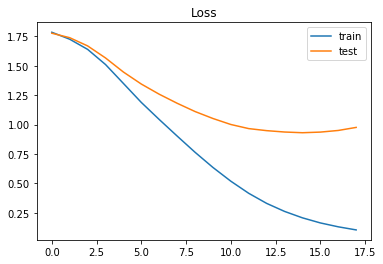

In [18]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

Text(0.5, 1.0, 'Accuracy')

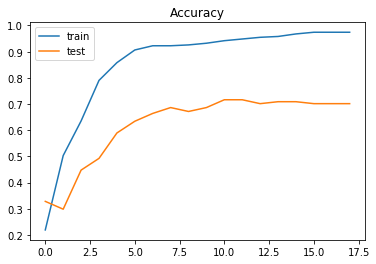

{'acc': [0.2193548436607084,
  0.5032258158729922,
  0.6354838763513873,
  0.7903225787224308,
  0.858064511129933,
  0.9064516021359351,
  0.9225806382394606,
  0.9225806363167302,
  0.9258064454601657,
  0.9322580541333845,
  0.9419354738727692,
  0.948387086391449,
  0.9548387008328592,
  0.9580645080535642,
  0.9677419297156795,
  0.9741935480025506,
  0.9741935441570897,
  0.9741935422343593],
 'loss': [1.7844427016473585,
  1.7256151937669324,
  1.6405326358733638,
  1.5124613431192213,
  1.3514500856399536,
  1.1899673342704773,
  1.0448718224802325,
  0.9054459198828666,
  0.7683216871753815,
  0.6392450649892131,
  0.5213411234078869,
  0.41697289962922374,
  0.33089674816977593,
  0.2622645264191012,
  0.2073049648634849,
  0.1634994241739473,
  0.1306323627791097,
  0.10415905101164695],
 'val_acc': [0.32835821473776405,
  0.29850746757948576,
  0.44776120381568796,
  0.4925373183257544,
  0.5895522445885103,
  0.634328354650469,
  0.6641791058120443,
  0.6865671641791045,
 

In [397]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();
history.history